In [17]:
import glob
import cv2 as cv
import numpy as np
import imutils
from matplotlib import pyplot as plt
from scipy import signal

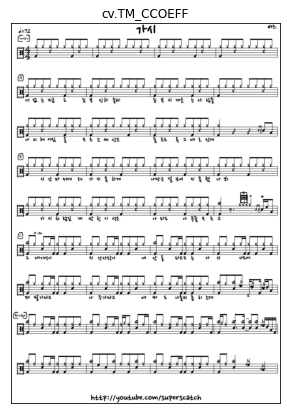

In [3]:
PATH = 'C:/Users/ADmin/Desktop/drum/music_sheet/'
img = cv.imread(PATH+'/7.jpg',0)

start = cv.imread('C:/Users/ADmin/Desktop/start.jpg')
start = cv.cvtColor(start, cv.COLOR_BGR2GRAY)

start_w,start_h = start.shape[::-1]

meth = 'cv.TM_CCOEFF'
method = eval(meth)
img2 = img.copy()
res = cv.matchTemplate(img2,start,method)
cv.normalize(res,res,0,1, norm_type=cv.NORM_MINMAX)

threshold = 0.9
loc = np.where(res > threshold)

point_w = []
point_h = []

for pt in zip(*loc[::-1]):
    cv.rectangle(img2, pt, (pt[0] + start_w, pt[1] + start_h), (0,0,255), 1)
    point_w.append(pt[0])
    point_h.append(pt[1])

plt.figure(figsize=[10,7])
plt.imshow(img2,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.title(meth)
plt.show()

In [5]:
i = 1
while i < len(point_h):
    prev = point_h[i-1]
    post = point_h[i]

    if (post-prev < 30):
        del point_h[i-1]
        del point_w[i-1]
    else:
        i += 1

In [6]:
crops = []

for i in range(len(point_h)):
    
    s = point_h[i]-start_h//2
    e = point_h[i]+start_h
    
    crops.append(img[s:e,point_w[i]+start_w:img.shape[1]])

(0.0, 816.0)

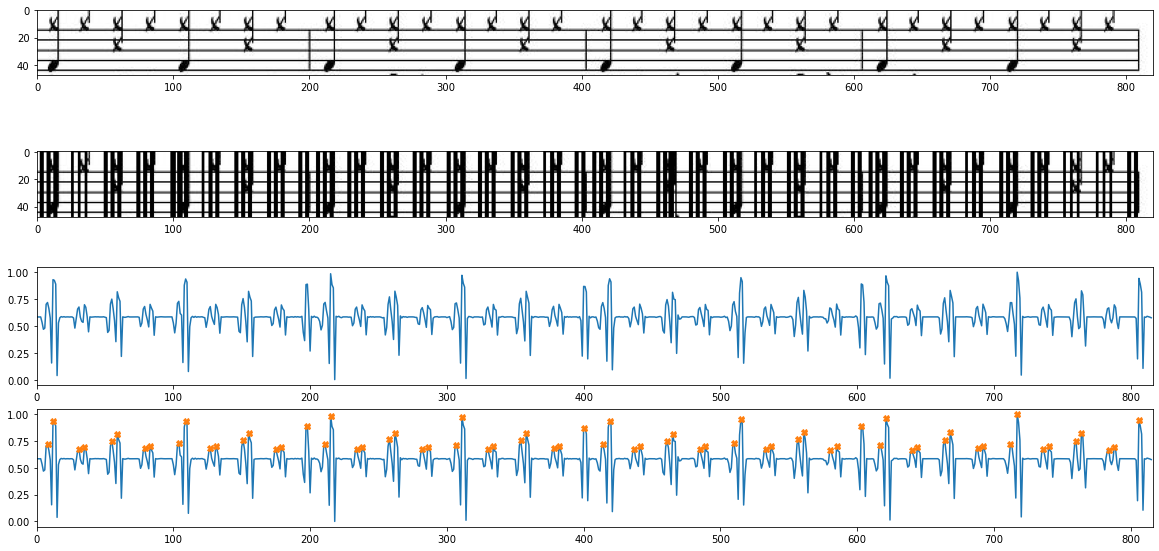

In [21]:
crop_img = crops[3]

line = np.zeros([crop_img.shape[0],1])
padd = np.ones([crop_img.shape[0],1])

lines = np.hstack([padd, line, line, line, padd])
lines = lines.astype(np.uint8)

lines_w,lines_h = lines.shape[::-1]

meth = 'cv.TM_CCOEFF'
method = eval(meth)
crop_img2 = crop_img.copy()
res = cv.matchTemplate(crop_img2,lines,method)
res_norm = res.copy()
cv.normalize(res,res_norm,0,1, norm_type=cv.NORM_MINMAX)

threshold = 0.6
loc = np.where(res_norm > threshold)

point_w = []
point_h = []

for pt in zip(*loc[::-1]):
    cv.rectangle(crop_img2, pt, (pt[0] - lines_w, pt[1] + lines_h), 0, 1)
    point_w.append(pt[0])
    point_h.append(pt[1])
    
profile = res_norm.T
prof = np.squeeze(profile, axis=1)    
peaks,_ = signal.find_peaks(prof, height=0.65)

plt.figure(figsize=[20,10])

plt.subplot(4,1,1),plt.imshow(crop_img,cmap = 'gray')
plt.subplot(4,1,2),plt.imshow(crop_img2,cmap = 'gray')
plt.subplot(4,1,3),plt.plot(profile)
plt.xlim(0,len(profile))
plt.subplot(4,1,4),plt.plot(prof),plt.plot(peaks,prof[peaks],"X")
plt.xlim(0,len(prof))

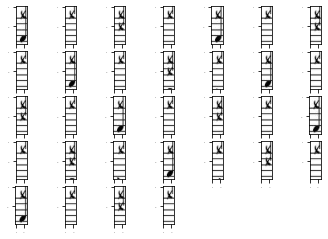

In [24]:
note_crops = []
all_point = np.append(0, peaks, crop_img.shape[1])
default_lines = crop_img[0:crop_img.shape[0],all_point[0]:all_point[1]]

for i in range(len(peaks)):
    if (all_point[i+1]-all_point[i]<8):
        crops = crop_img[0:crop_img.shape[0],all_point[i]-5:all_point[i+1]+5]
    else:
        continue
    note_crops.append(crops)
    
for i in range(len(note_crops)):
    plt.subplot(5,len(note_crops)//5+1,i+1)
    plt.imshow(note_crops[i],cmap='gray')
    plt.xticks(fontsize=0.1)
    plt.yticks(fontsize=0.1)

two note
[(8, 40), (8, 10)]


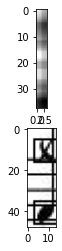

In [33]:
square = np.zeros([7,7])
square = np.pad(square,(2,2),mode = 'constant', constant_values = 1)
square = square.astype(np.uint8)

def one_or_two(note_crop, method):
    process_img = note_crop.copy()
    img = note_crop.copy()

    method = eval(method)
    orig_res = cv.matchTemplate(process_img,square,method)
    
    points = []
    
    for i in range(2):
        res = cv.matchTemplate(process_img,square,method)
        res_norm = res.copy()

        cv.normalize(res,res_norm,0,1, norm_type=cv.NORM_MINMAX)

        minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(res_norm)

        x,y = minLoc
        h,w = square.shape        

        if i == 0:
            process_img[y:y+h, x:x+w] = np.max(process_img)
            cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
        else:
            avg = np.mean(process_img[y:y+h, x:x+w])

            if avg < 180:
                cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
                print ("two note")
            else:
                print ("one note")
                break
        
        point = x+w//2,y+h//2
        points.append(point)
                
    return orig_res,img,points

orig_res, img, points = one_or_two(note_crops[0], 'cv.TM_SQDIFF')

print(points)

plt.figure(figsize=[10,4])
plt.title(method)
plt.subplot(2,1,1), plt.imshow(orig_res,cmap = 'gray')
plt.subplot(2,1,2), plt.imshow(img,cmap = 'gray')

plt.show()

dtype('uint8')

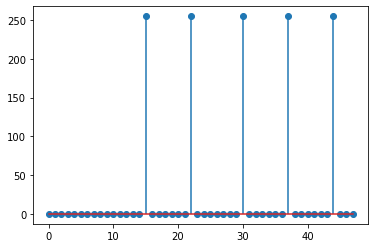

In [34]:
ret, thresh = cv.threshold(note_crops[0], 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

f_line = thresh[:,0]
plt.stem(f_line)
f_line.dtype

In [44]:
line = np.where(f_line==255)

ride = [0,line[0][0]-7]
hihat = [line[0][0]-7,line[0][0]]
snare = [line[0][2] - 1,line[0][2] + 1]
h_tom = [(line[0][0]+line[0][1])//2 - 1,(line[0][0]+line[0][1])//2 + 1]
m_tom = [(line[0][1]+line[0][2])//2 - 1,(line[0][1]+line[0][2])//2 + 1]
l_tom = [(line[0][2]+line[0][3])//2 - 1,(line[0][2]+line[0][3])//2 + 1]
bass = [(line[0][3]+line[0][4])//2 - 1,(line[0][3]+line[0][4])//2 + 1]

note = []
for i in range(len(points)):
    if ride[0] <= points[i][1] <=  ride[1]:
        note.append('Ride')
    elif hihat[0] <= points[i][1] <=  hihat[1]:
        note.append('Hihat')
    elif snare[0] <= points[i][1] <=  snare[1]:
        note.append('Snare')
    elif h_tom[0] <= points[i][1] <=  h_tom[1]:
        note.append('High_Tom')
    elif m_tom[0] <= points[i][1] <=  m_tom[1]:
        note.append('Mid_Tom')
    elif l_tom[0] <= points[i][1] <=  l_tom[1]:
        note.append('Low_Tom')   
    else:
        note.append('Bass')     

In [45]:
note

['Bass', 'Hihat']